In [3]:
from spreg import OLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from scipy import stats
from pysal.lib import weights
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy import sparse
import warnings
from pysal.explore import esda
from spglm.family import Poisson, Binomial



/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/Users/kendall/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. Se

In [4]:
data = gpd.read_file("scraped_gwr.geojson")

In [5]:
data = data.to_crs(5070)

In [6]:
print(data.crs)

EPSG:5070


In [7]:
data["address_ID"].nunique()

2170

In [8]:
display(data.sample(5))

,area_id,address_ID,has_FTTH,category,redlined,bb_adoption_prop,black_prop,gen_disp,pop_density,geometry
806,1524,10436939,0,Definitely Declining,0,0.542614,0.952788,0,3106.809182,POINT (690403.199 2113558.748)
945,1515,10446673,0,Definitely Declining,0,0.610623,0.924576,0,1848.690268,POINT (693487.645 2114314.915)
1443,1265,10694560,0,Definitely Declining,0,0.780652,0.072692,1,9808.129779,POINT (681377.558 2131456.544)
949,1570,10405866,0,Still Desirable,0,0.611115,0.918585,0,2976.827478,POINT (693683.252 2112440.848)
901,1599,10349904,0,Hazardous,1,0.781820,0.011353,0,2750.674450,POINT (684296.359 2107279.849)


In [9]:
print(type(data["has_FTTH"].iloc[0]))

<class 'numpy.int64'>


#### Weighted Logistic Regression and Assessing Spatial Patterns in the Residuals
- baseline global model to compare with local results of the GWLR
- provides initial insights into overall relationships between explanatory and dependent variables
- check for spatial nonstationarity by looking at residual patterns
- Weighted Logistic regression can help if certain areas are over or underrepresented in the dataset


In [10]:
# prepare dependent and independent variables
y = np.array(data['has_FTTH'])
X = data[['redlined', 'bb_adoption_prop', 'black_prop', 'gen_disp', 'pop_density']]

# scale pop_density (continuous variable, not a proportion) for numerical stability 

scaler = StandardScaler()
# display(X.head())
X['pop_density'] = np.log1p(X['pop_density'])
X['pop_density'] = scaler.fit_transform(X[['pop_density']])
# display(X.head())

print(X['pop_density'].mean())
print(X['pop_density'].std())

print(type(X))
X_df = X.copy()

X = np.array(X.assign(constant=1) )

X = X.astype(float)
y = y.astype(float)
y = y.reshape(-1, 1)


# get coordinates of centroid of each polygon
# coords = np.column_stack((data.geometry.centroid.x,data.geometry.centroid.y))
coords = np.array([(geom.x, geom.y) for geom in data.geometry])

# calculate spatial weights (using same kernel weight from autocorrelation)
# CHANGE: k = 11 to account for sparseness in this point data (weights matrix is disconnected for k <= 10)
w_adapt = weights.distance.Kernel.from_dataframe(
    data, fixed=False, k=11, function="gaussian", diagonal = False
)

w_adapt.transform = "R" # only using row standardization for spatial autocorrelation

# w_adapt.diagonal = 0

w_adapt = w_adapt.full()[0] #convert to dense matrix

# # sum elemnts of weights matrix to get the correct form --> This approach ensures that each observation's contribution to the regression is weighted according to its spatial context or connectivity as defined by the weights matrix.
# freq_weights = w_adapt.sum(axis=1)


1.9646342924242403e-16
1.0002304944135716
<class 'pandas.core.frame.DataFrame'>


/var/folders/q_/hxs6bprd6qz5xsd01jm_081h0000gn/T/ipykernel_62969/2098632114.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pop_density'] = np.log1p(X['pop_density'])
/var/folders/q_/hxs6bprd6qz5xsd01jm_081h0000gn/T/ipykernel_62969/2098632114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pop_density'] = scaler.fit_transform(X[['pop_density']])


In [11]:
print(X_df.describe())

          redlined  bb_adoption_prop   black_prop     gen_disp   pop_density
count  2170.000000       2170.000000  2170.000000  2170.000000  2.170000e+03
mean      0.296774          0.691203     0.271189     0.193088  1.964634e-16
std       0.456941          0.145922     0.347624     0.394812  1.000230e+00
min       0.000000          0.037612     0.000000     0.000000 -4.501870e+00
25%       0.000000          0.602999     0.027804     0.000000 -5.996342e-01
50%       0.000000          0.714066     0.054647     0.000000 -5.315085e-02
75%       1.000000          0.795925     0.511571     0.000000  6.359906e-01
max       1.000000          0.994822     0.996869     1.000000  2.857181e+00


In [12]:
freq_weights = w_adapt.diagonal()

In [13]:
print(freq_weights.shape)

(2170,)


In [14]:
type(freq_weights)

numpy.ndarray

In [15]:
print(freq_weights)

[0.10292434 0.10474086 0.10747313 ... 0.09799529 0.09967904 0.10006688]


In [16]:
print("Weight Statistics:")
print(f"Minimum: {np.min(freq_weights)}")
print(f"Maximum: {np.max(freq_weights)}")
print(f"Range: {np.ptp(freq_weights)}")  # Peak to peak (max - min)
print(f"Mean: {np.mean(freq_weights)}")
print(f"Median: {np.median(freq_weights)}")
print(f"Standard Deviation: {np.std(freq_weights)}")

# Percentiles
percentiles = [0, 25, 50, 75, 100]
print("\nPercentiles:")
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(freq_weights, p)}")

# Count of zero weights
zero_weights = np.sum(freq_weights == 0)
print(f"\nNumber of zero weights: {zero_weights}")
print(f"Proportion of zero weights: {zero_weights / len(freq_weights):.2%}")

Weight Statistics:
Minimum: 0.092393236135737
Maximum: 0.11992857481905013
Range: 0.027535338683313135
Mean: 0.10465852083810961
Median: 0.1044366248323794
Standard Deviation: 0.004408245727129021

Percentiles:
0th percentile: 0.092393236135737
25th percentile: 0.1016028283253918
50th percentile: 0.1044366248323794
75th percentile: 0.10770957583082161
100th percentile: 0.11992857481905013

Number of zero weights: 0
Proportion of zero weights: 0.00%


In [17]:
# Run weighted logit model 
wlogit_model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=freq_weights)
wlogit_results = wlogit_model.fit()

print(wlogit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2170
Model:                            GLM   Df Residuals:                   221.11
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94.419
Date:                Tue, 27 Aug 2024   Deviance:                       188.84
Time:                        23:53:10   Pearson chi2:                     343.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02385
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.5894      0.516     -3.081      0.0

In [18]:
# null model for deviance comparison --> https://lifewithdata.com/2023/06/06/how-to-perform-a-likelihood-ratio-test-in-python/
X_null = sm.add_constant(np.ones(len(y)))  # This creates a column of 1s for the intercept

# Fit the null model
null_model = sm.GLM(y, X_null, family=sm.families.Binomial())
null_results = null_model.fit()

In [19]:
null_deviance = null_results.deviance
print(null_deviance)

2303.3707530276615


In [20]:
# Your current approach
print(f"Null deviance (from separate null model): {null_results.deviance}")
print(f"Model deviance (from full model): {wlogit_results.deviance}")

# Extracting null deviance from the full model results
print(f"Null deviance (from full model object): {wlogit_results.null_deviance}")

# Calculate percent deviance explained using both methods
pct_dev_1 = ((null_results.deviance - wlogit_results.deviance) / null_results.deviance) * 100
pct_dev_2 = ((wlogit_results.null_deviance - wlogit_results.deviance) / wlogit_results.null_deviance) * 100

print(f"Percent deviance explained (using separate null model): {pct_dev_1:.2f}%")
print(f"Percent deviance explained (using full model's null_deviance): {pct_dev_2:.2f}%")

Null deviance (from separate null model): 2303.3707530276615
Model deviance (from full model): 188.8388345205819
Null deviance (from full model object): 241.2211985717259
Percent deviance explained (using separate null model): 91.80%
Percent deviance explained (using full model's null_deviance): 21.72%


In [22]:
# Assuming you've already fit your model
# model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

def adjusted_pct_deviance_explained(model):
    # Get the number of observations and predictors
    n = model.nobs
    p = model.df_model  # number of predictors (excluding intercept)

    # Calculate null and residual deviances
    null_deviance = model.null_deviance
    residual_deviance = model.deviance

    # Calculate unadjusted percent deviance explained
    pct_dev_explained = (null_deviance - residual_deviance) / null_deviance

    # Calculate adjusted percent deviance explained
    adj_pct_dev_explained = 1 - ((n - 1) / (n - p - 1)) * (1 - pct_dev_explained)

    return pct_dev_explained, adj_pct_dev_explained

# Use the function
pct_dev, adj_pct_dev = adjusted_pct_deviance_explained(wlogit_results)

print(f"Percent Deviance Explained: {pct_dev:.4f}")
print(f"Adjusted Percent Deviance Explained: {adj_pct_dev:.4f}")

Percent Deviance Explained: 0.2172
Adjusted Percent Deviance Explained: 0.2153


In [23]:
# Calculate the test statistic
LR_statistic = -2 * (null_results.llf - wlogit_results.llf)

# Calculate degrees of freedom (difference in number of parameters)
df = wlogit_results.df_model - null_results.df_model

# Calculate p-value
p_value = stats.chi2.sf(LR_statistic, df)

print(f"Likelihood Ratio Test Statistic: {LR_statistic}")
print(f"Degrees of Freedom: {df}")
print(f"P-value: {p_value}")

Likelihood Ratio Test Statistic: 2114.531918507079
Degrees of Freedom: 5
P-value: 0.0


In [24]:
# plot residuals
map_1_gdf = data.copy()
map_1_gdf["WLogit_residuals"] = wlogit_results.resid_deviance
display(map_1_gdf)


,area_id,address_ID,has_FTTH,category,redlined,bb_adoption_prop,black_prop,gen_disp,pop_density,geometry,WLogit_residuals
0,1152,10886721,0,Definitely Declining,0,0.785651,0.300119,1,9467.228767,POINT (683746.599 2142518.008),-0.575809
1,1152,10888120,0,Definitely Declining,0,0.785651,0.300119,1,9467.228767,POINT (683825.431 2142718.692),-0.575809
2,1167,10889247,0,Definitely Declining,0,0.774474,0.267848,0,10501.176840,POINT (684045.234 2142487.344),-0.466907
3,1172,10890447,0,Definitely Declining,0,0.723288,0.163723,0,8015.893229,POINT (684589.678 2143088.740),-0.645060
4,1172,10890425,0,Definitely Declining,0,0.723288,0.163723,0,8015.893229,POINT (684589.837 2143086.751),-0.645060
...,...,...,...,...,...,...,...,...,...,...,...
2165,1180,10852182,1,Still Desirable,0,0.632414,0.027804,0,3574.168618,POINT (681046.630 2139241.689),1.223541
2166,1180,10846179,0,Still Desirable,0,0.632414,0.027804,0,3574.168618,POINT (680796.169 2138734.289),-1.131967
2167,5653,10822730,0,Definitely Declining,0,0.701936,0.041555,1,10189.169167,POINT (681830.985 2137554.837),-0.896102
2168,5653,10821881,1,Definitely Declining,0,0.701936,0.041555,1,10189.169167,POINT (681801.038 2137460.836),1.487677


In [25]:
map_1_gdf = map_1_gdf.to_crs(5070)

In [26]:
w_adapt2 = weights.distance.Kernel.from_dataframe(
    data, fixed=False, k=11, function="gaussian", diagonal = False
)

In [27]:
fcc_holc = gpd.read_file("fcc_holc.geojson")

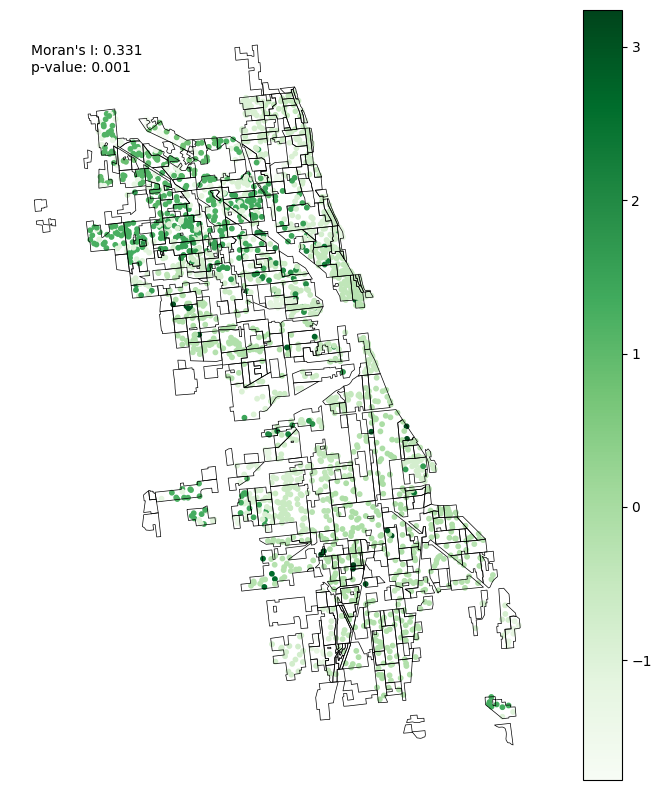

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
map_1_gdf.plot(ax=ax, column="WLogit_residuals", legend=True, cmap='Greens', markersize = 10)
fcc_holc.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.5)
plt.axis("off")
resid_moran = esda.Moran(map_1_gdf["WLogit_residuals"], w_adapt2)
plt.text(0.04, 0.92, f"Moran's I: {resid_moran.I:.3f}\np-value: {resid_moran.p_sim:.3f}", transform=plt.gca().transAxes)
plt.show()

#### Check Variance Inflation Factor

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif = calculate_vif(X_df)
print(vif)

           Variable       VIF
0          redlined  1.458051
1  bb_adoption_prop  1.952435
2        black_prop  1.696240
3          gen_disp  1.309700
4       pop_density  1.267784


#### GWLR with Adaptive Bandwidth

In [30]:
print(len(X_df))

2170


In [31]:
X_df_no_na = X_df.dropna()
print(len(X_df_no_na))

2170


In [32]:
display(X_df.sample(5))

,redlined,bb_adoption_prop,black_prop,gen_disp,pop_density
1051,0,0.820461,0.104733,0,-0.894207
1578,1,0.618840,0.590484,0,-0.948713
2113,0,0.754104,0.006588,0,-0.569995
1427,0,0.785497,0.026699,1,0.999766
2039,1,0.795925,0.045123,0,2.374049


In [33]:
X_main = X[:, 0].reshape(-1, 1) 

In [34]:
X_1 = np.array(X_df[["redlined","bb_adoption_prop", "black_prop", "gen_disp", "pop_density"]]) # works for GWR, but not with pop density
#X_1 = np.array(X_df[["redlined","bb_adoption_prop", "black_prop"]])

In [35]:
data_2 = data.sample(100)

# prepare dependent and independent variables
y_2 = np.array(data_2['has_FTTH'])
X_2 = data_2[['redlined', 'bb_adoption_prop', 'black_prop', 'gen_disp', 'pop_density']]

# scale pop_density (continuous variable, not a proportion) for numerical stability 
scaler = StandardScaler()
# display(X.head())
X_2['pop_density'] = scaler.fit_transform(X_2[['pop_density']])
# display(X.head())

# print(type(X))
# X_df = X.copy()

X_2 = np.array(X_2.assign(constant=1) )

X_2 = X_2.astype(float)
y_2 = y_2.astype(float)
y_2 = y_2.reshape(-1, 1)


# get coordinates of centroid of each polygon
# coords = np.column_stack((data.geometry.centroid.x,data.geometry.centroid.y))
coords_2 = np.array([(geom.x, geom.y) for geom in data_2.geometry])

/var/folders/q_/hxs6bprd6qz5xsd01jm_081h0000gn/T/ipykernel_62969/2555085130.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['pop_density'] = scaler.fit_transform(X_2[['pop_density']])


In [36]:
print(data.crs)

EPSG:5070


In [37]:
data = data.to_crs(5070)

In [40]:
print(y_2.shape)

(100, 1)


In [41]:
print(X_2.shape)

(100, 6)


In [91]:
warnings.filterwarnings('ignore')

bw_selector = Sel_BW(coords_filtered, y_filtered, X_filtered, kernel='gaussian', fixed=False, family = Binomial()) # try with adaptive bandwidth (fixed = false) and check results

bw = bw_selector.search()

print(bw) # output for this is 84...dont run again. it took forever haha. #72 for X_2/subset

/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi

53.0


In [42]:
correlation_matrix = X_df.corr()
print(correlation_matrix)

                  redlined  bb_adoption_prop  black_prop  gen_disp  \
redlined          1.000000         -0.073417    0.071973  0.052777   
bb_adoption_prop -0.073417          1.000000   -0.448850  0.048750   
black_prop        0.071973         -0.448850    1.000000  0.081469   
gen_disp          0.052777          0.048750    0.081469  1.000000   
pop_density      -0.177444          0.357007   -0.365922  0.151618   

                  pop_density  
redlined            -0.177444  
bb_adoption_prop     0.357007  
black_prop          -0.365922  
gen_disp             0.151618  
pop_density          1.000000  


In [43]:
from scipy.spatial import cKDTree

def get_adaptive_weights(coords, nn):
    kdtree = cKDTree(coords)
    distances, _ = kdtree.query(coords, k=nn)
    return distances[:, -1]  # returns the distance to the nn-th neighbor for each point

In [44]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def local_vif_adaptive(X, coords, nn, kernel='gaussian'):
    n, k = X.shape
    vif_values = np.zeros((n, k))
    
    # Get adaptive bandwidths
    adaptive_bw = get_adaptive_weights(coords, nn)
    
    for i in range(n):
        dists = np.sqrt(((coords - coords[i])**2).sum(axis=1))
        bw = adaptive_bw[i]
        
        if kernel == 'gaussian':
            w = np.exp(-0.5 * (dists / bw)**2)
        else:  # bisquare
            w = (1 - (dists / bw)**2)**2 * (dists <= bw)
        
        xw = w[:, np.newaxis] * X
        
        for j in range(k):
            vif_values[i, j] = variance_inflation_factor(xw, j)
    
    return vif_values

In [45]:
# Assuming you have your X_1 and coords ready
nn = 84  # This should be the number of nearest neighbors you're using in your GWR model

local_vifs_adaptive = local_vif_adaptive(X_1, coords, nn, kernel='gaussian')

print("Summary of local VIFs (Adaptive Bandwidth):")
for j in range(X_1.shape[1]):
    print(f"Variable {j}:")
    print(pd.Series(local_vifs_adaptive[:, j]).describe())
    print()

Summary of local VIFs (Adaptive Bandwidth):
Variable 0:
count    2170.000000
mean        2.422582
std         2.047381
min         1.000002
25%         1.045684
50%         1.564884
75%         2.922289
max        11.908780
dtype: float64

Variable 1:
count    2170.000000
mean        6.892884
std         5.555869
min         1.314016
25%         3.295716
50%         5.140266
75%         8.692362
max        35.119601
dtype: float64

Variable 2:
count    2170.000000
mean        5.268695
std         5.049821
min         1.199205
25%         2.093269
50%         3.435454
75%         6.585474
max        35.522195
dtype: float64

Variable 3:
count    2170.000000
mean        1.901437
std         1.112140
min         1.000581
25%         1.166600
50%         1.528704
75%         2.143360
max         8.119909
dtype: float64

Variable 4:
count    2170.000000
mean        2.934821
std         2.029146
min         1.046507
25%         1.828908
50%         2.569942
75%         3.409165
max        19

In [46]:
high_vif_locations = np.any(local_vifs_adaptive > 10, axis=1)
problematic_points = np.where(high_vif_locations)[0]
print(f"Number of locations with high VIF: {len(problematic_points)}")

Number of locations with high VIF: 473


In [62]:
#proportion of problematic locations
473/len(X_1)

0.21797235023041475

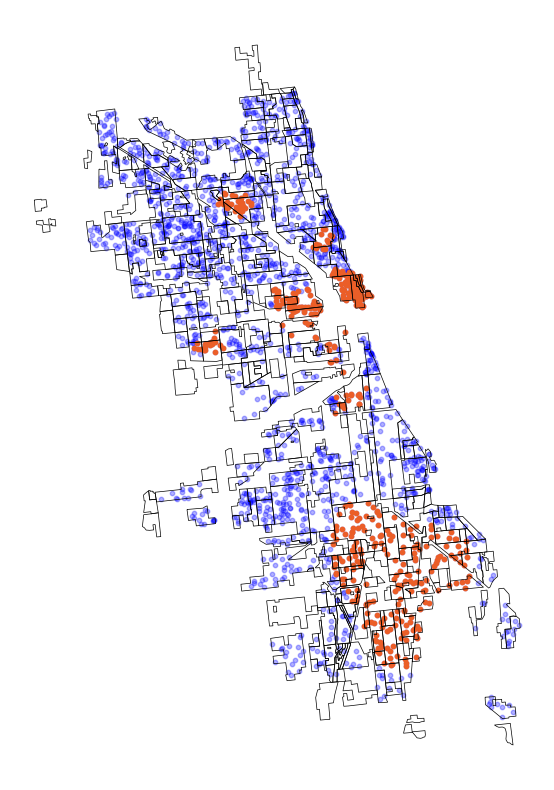

In [48]:
#plot problematic areas --> see if there is spatial autocorrelation.

#may also want to find a way to map areas where specific variables are highly correlated (e.g. black population and redlining; gentrification and redlining; redlining and broadband adoption)

# Plot problematic locations
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.scatter(coords[:, 0], coords[:, 1], c='blue', alpha=0.3, label='All points', s=10)
plt.scatter(coords[problematic_points, 0], coords[problematic_points, 1], c='#EB5E28', label='High VIF points', s=10)
fcc_holc.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.5)
#plt.legend()
plt.axis("off")
# plt.title('Spatial Distribution of High VIF Points')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
plt.show()

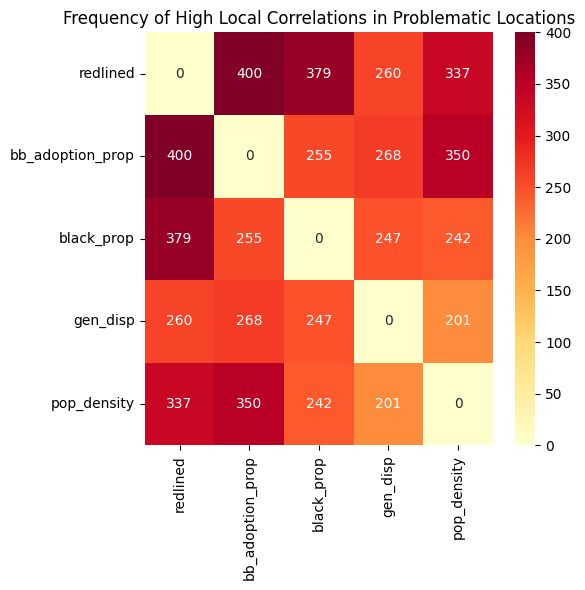

Most frequent high correlations:
redlined - bb_adoption_prop: 400.0 locations
redlined - black_prop: 379.0 locations
redlined - gen_disp: 260.0 locations
redlined - pop_density: 337.0 locations
bb_adoption_prop - black_prop: 255.0 locations
bb_adoption_prop - gen_disp: 268.0 locations
bb_adoption_prop - pop_density: 350.0 locations
black_prop - gen_disp: 247.0 locations
black_prop - pop_density: 242.0 locations
gen_disp - pop_density: 201.0 locations


In [66]:
import numpy as np
from scipy.spatial import cKDTree
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_adaptive_weights(coords, nn):
    kdtree = cKDTree(coords)
    distances, _ = kdtree.query(coords, k=nn)
    return distances[:, -1]

def weighted_correlation(x, y, weights):
    wx = weights * x
    wy = weights * y
    return np.cov(wx, wy)[0, 1] / np.sqrt(np.cov(wx, wx)[0, 0] * np.cov(wy, wy)[0, 0])

def local_correlation_matrix(X, coords, nn, problematic_indices):
    n, k = X.shape
    local_corr_matrix = np.zeros((len(problematic_indices), k, k))
    adaptive_bw = get_adaptive_weights(coords, nn)
    kdtree = cKDTree(coords)
    
    for idx, i in enumerate(problematic_indices):
        distances, indices = kdtree.query(coords[i], k=nn)
        weights = np.exp(-0.5 * (distances / adaptive_bw[i])**2)
        weights /= np.sum(weights)
        local_data = X[indices]
        for j in range(k):
            for l in range(j+1, k):
                # Skip correlation calculation if either variable is the constant term
                if j == k-1 or l == k-1:
                    corr = 0
                else:
                    corr = weighted_correlation(local_data[:, j], local_data[:, l], weights)
                local_corr_matrix[idx, j, l] = corr
                local_corr_matrix[idx, l, j] = corr
    
    return local_corr_matrix

# Assuming you have:
# X: your feature matrix
# coords: your coordinate array
# problematic_indices: indices of the ~400 problematic locations
# variable_names: list of variable names corresponding to columns in X

variable_names = ['redlined', 'bb_adoption_prop', 'black_prop', 'gen_disp', 'pop_density', 'constant']

nn = 84  # Your bandwidth

# Calculate local correlations for problematic locations
local_corr_matrix = local_correlation_matrix(X, coords, nn, problematic_points)

# Identify highly correlated pairs
high_corr_threshold = 0.5  # Adjust as needed
high_corr_counts = np.zeros((X.shape[1], X.shape[1]))

for i in range(X.shape[1]):
    for j in range(i+1, X.shape[1]):
        # Skip the constant term
        if i == X.shape[1]-1 or j == X.shape[1]-1:
            continue
        high_corr_counts[i, j] = np.sum(np.abs(local_corr_matrix[:, i, j]) < high_corr_threshold)
        high_corr_counts[j, i] = high_corr_counts[i, j]

# Create a DataFrame for easier visualization
high_corr_df = pd.DataFrame(high_corr_counts, index=variable_names, columns=variable_names)
high_corr_df = high_corr_df.drop('constant', axis=0).drop('constant', axis=1)

# Visualize the frequency of high correlations
plt.figure(figsize=(6, 6))
sns.heatmap(high_corr_df, annot=True, cmap='YlOrRd', fmt='g')
plt.title('Frequency of High Local Correlations in Problematic Locations')
plt.tight_layout()
plt.show()

# Print summary of most frequent high correlations
print("Most frequent high correlations:")
for i in range(X.shape[1]):
    for j in range(i+1, X.shape[1]):
        if high_corr_counts[i, j] > 0:
            print(f"{variable_names[i]} - {variable_names[j]}: {high_corr_counts[i, j]} locations")

In [203]:
def get_top_correlated_pairs(high_corr_df, n=9):
    pairs = []
    for i in range(len(high_corr_df.columns)):
        for j in range(i+1, len(high_corr_df.columns)):
            pairs.append((high_corr_df.columns[i], high_corr_df.columns[j], high_corr_df.iloc[i, j]))
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:n]

top_pairs = get_top_correlated_pairs(high_corr_df)

In [205]:
print(top_pairs)

[('black_prop', 'pop_density', np.float64(139.0)), ('bb_adoption_prop', 'black_prop', np.float64(89.0)), ('gen_disp', 'pop_density', np.float64(76.0)), ('redlined', 'gen_disp', np.float64(48.0)), ('bb_adoption_prop', 'gen_disp', np.float64(44.0)), ('redlined', 'pop_density', np.float64(19.0)), ('redlined', 'bb_adoption_prop', np.float64(17.0)), ('black_prop', 'gen_disp', np.float64(17.0)), ('bb_adoption_prop', 'pop_density', np.float64(10.0))]


In [209]:

def plot_correlated_pair(ax, coords, problematic_indices, local_corr_matrix, var1, var2, var_names, high_corr_threshold=0.7):
    # Create a GeoDataFrame for all points
    gdf_all = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(coords[:, 0], coords[:, 1]),
        crs="EPSG:4326"  # Adjust this to your coordinate system
    )
    
    # Create a GeoDataFrame for highly correlated points
    var1_index = var_names.index(var1)
    var2_index = var_names.index(var2)
    high_corr_mask = np.abs(local_corr_matrix[:, var1_index, var2_index]) > high_corr_threshold
    high_corr_indices = problematic_indices[high_corr_mask]
    
    gdf_high_corr = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(coords[high_corr_indices, 0], coords[high_corr_indices, 1]),
        crs="EPSG:5070"  # Adjust this to your coordinate system
    )
    
    # Plot
    gdf_all.plot(ax=ax, color='blue', alpha=0.1, markersize=2)
    gdf_high_corr.plot(ax=ax, color='red', alpha=0.5, markersize=4)
    fcc_holc.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.4)
    
    #ax.set_title(f"{var1} - {var2}")
    ax.axis('off')

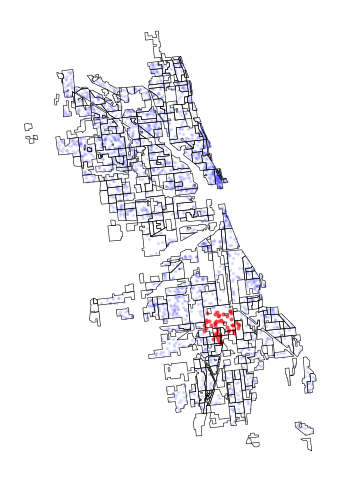

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_correlated_pair(ax, coords, problematic_points, local_corr_matrix, 'redlined','gen_disp', variable_names)

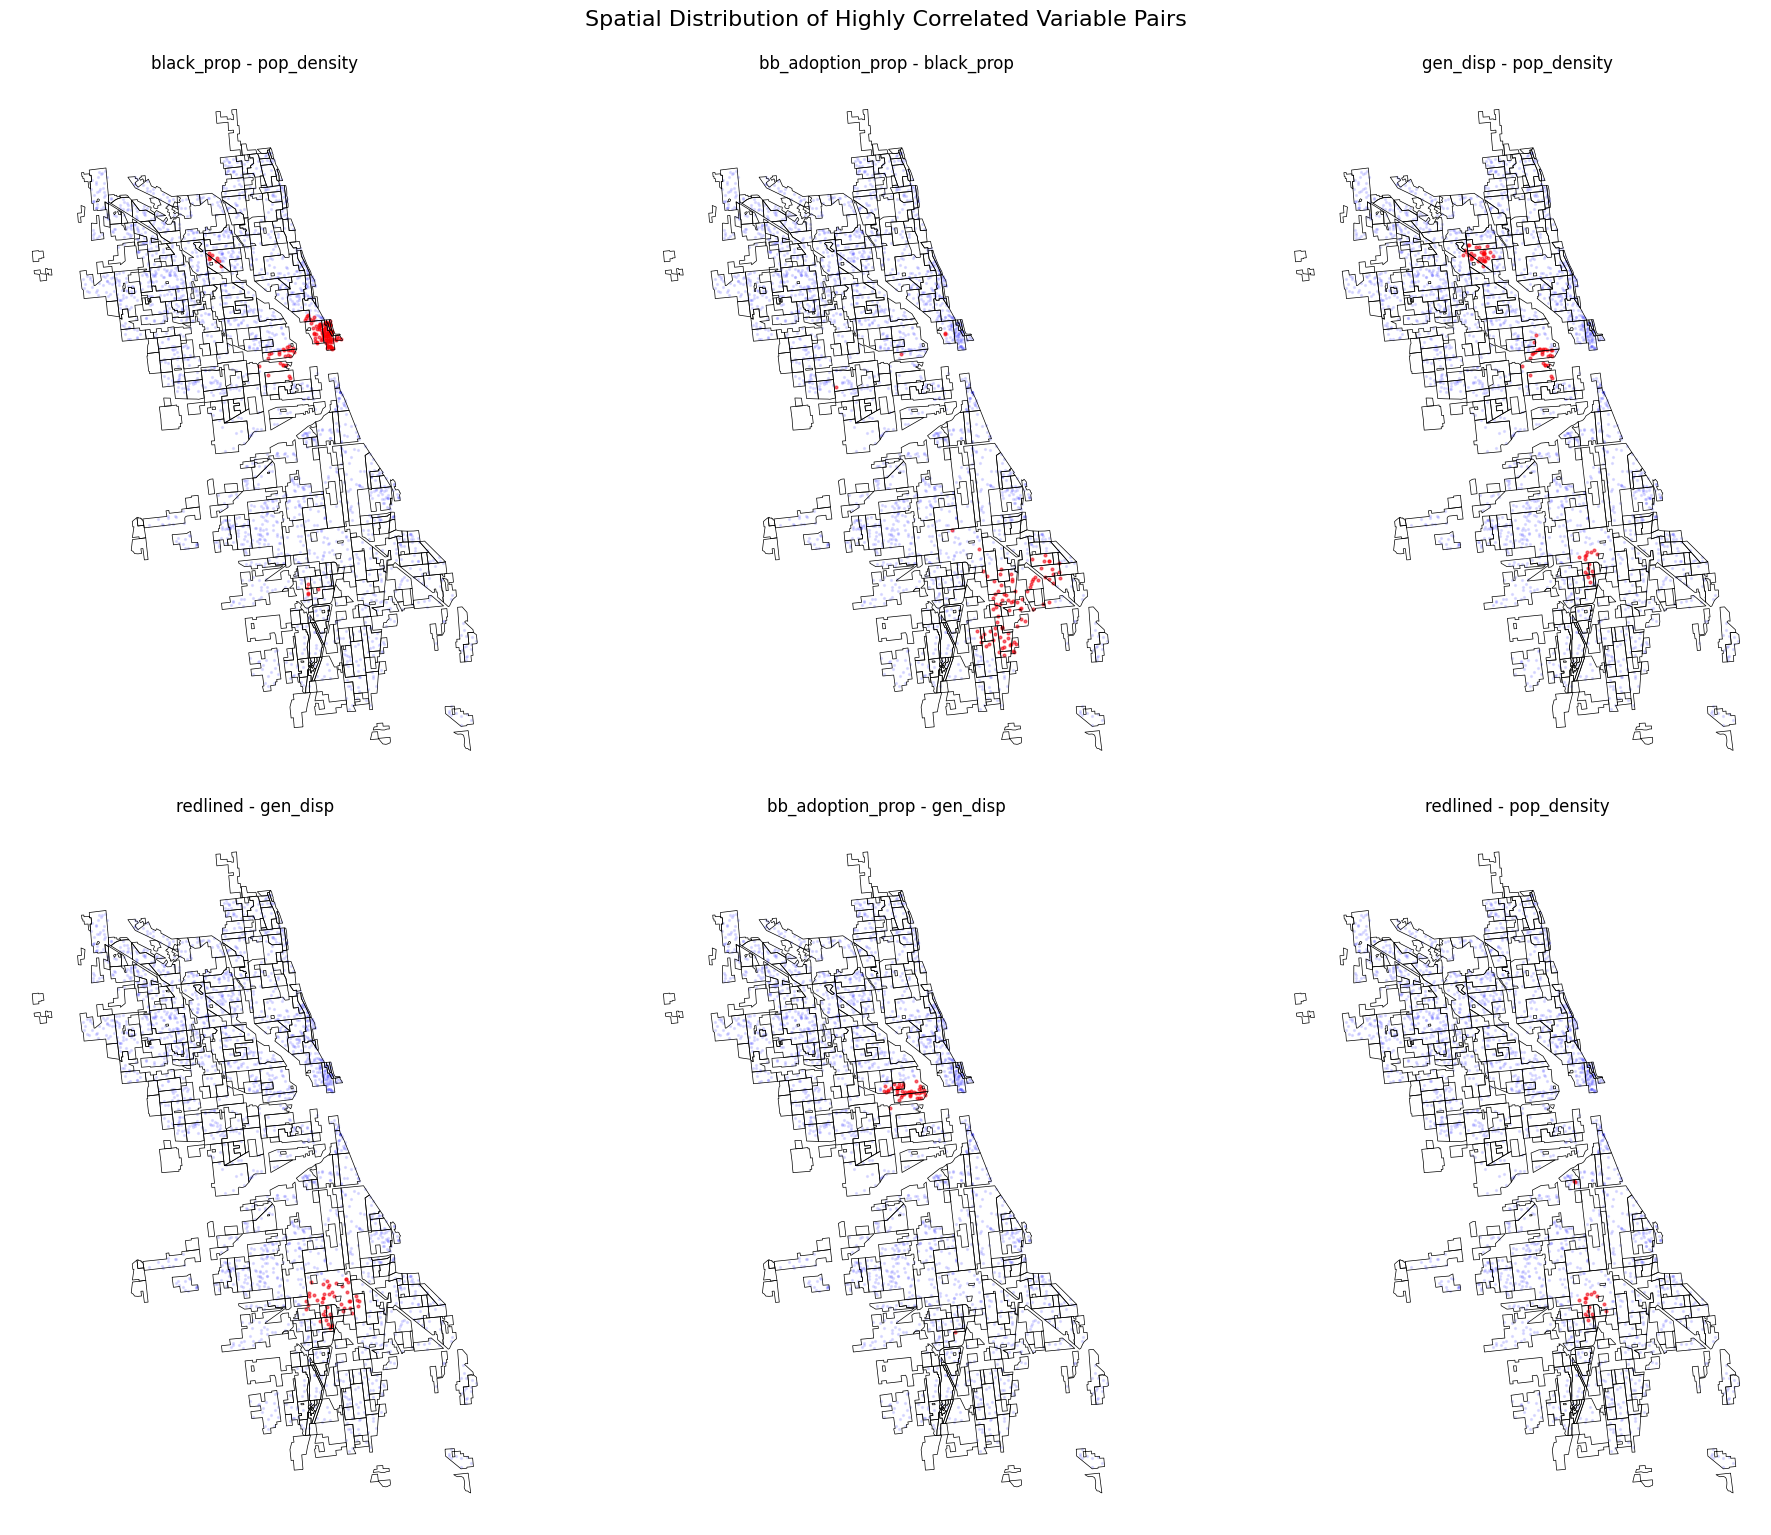

In [202]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))
axes = axes.flatten()

for i, (var1, var2, _) in enumerate(top_pairs):
    plot_correlated_pair(axes[i], coords, problematic_points, local_corr_matrix, var1, var2, variable_names)

plt.tight_layout()
plt.suptitle("Spatial Distribution of Highly Correlated Variable Pairs", fontsize=16, y=1.02)
plt.show()

In [171]:
print(X[0])

[0.         0.78565073 0.300119   1.         1.06426167 1.        ]


In [174]:
print(list(X_df.columns))

['redlined', 'bb_adoption_prop', 'black_prop', 'gen_disp', 'pop_density']


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
map_1_gdf.plot(ax=ax, column="WLogit_residuals", legend=True, cmap='Greens', markersize = 10)
fcc_holc.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.5)
plt.axis("off")
resid_moran = esda.Moran(map_1_gdf["WLogit_residuals"], w_adapt2)
plt.text(0.04, 0.92, f"Moran's I: {resid_moran.I:.3f}\np-value: {resid_moran.p_sim:.3f}", transform=plt.gca().transAxes)
plt.show()

In [49]:
# filtered data (try as input for GWLR)
X_filtered = X_1[~high_vif_locations]
coords_filtered = coords[~high_vif_locations]
y_filtered = y[~high_vif_locations]

In [50]:
# Fit GWR model
gwr_model_adapt = GWR(coords_filtered, y_filtered, X_filtered, bw=53, kernel='gaussian', family = Binomial(), fixed=False).fit()
print(gwr_model_adapt.summary())

/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi

Model type                                                         Binomial
Number of observations:                                                1697
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                          1580.990
Log-likelihood:                                                    -790.495
AIC:                                                               1592.990
AICc:                                                              1593.040
BIC:                                                             -10994.329
Percent deviance explained:                                           0.194
Adj. percent deviance explained:                                      0.191

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

381


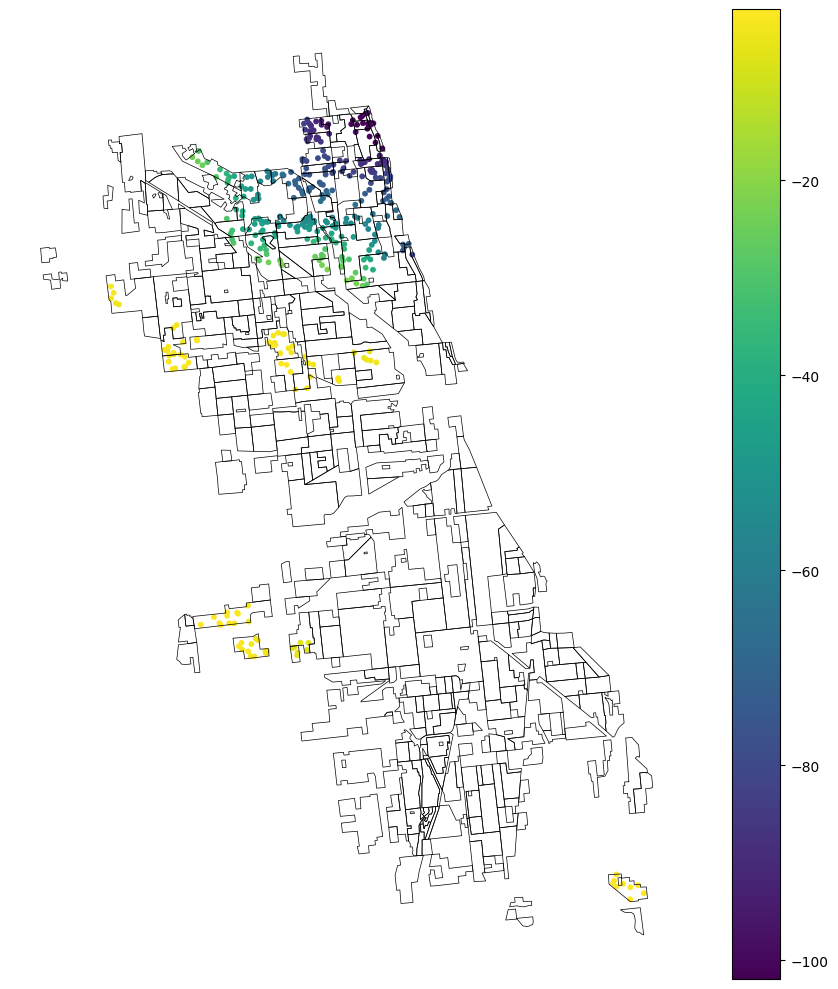

In [61]:

# Using filtered coordinates and data
# gwr_model_adapt is your fitted GWR model
# coords_filtered is your array of filtered coordinates

# Create a GeoDataFrame with your filtered points
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(coords_filtered[:, 0], coords_filtered[:, 1]),
    crs="EPSG:5070"  # Use the appropriate coordinate reference system
)

# Add parameter estimates and t-values to the GeoDataFrame
# Let's say we're interested in the 4th variable (index 3)
variable_index = 3 # 1="redlined", 2="bb_adoption_prop", 3="black_prop",4= "gen_disp", 5="pop_density"
gdf['parameter_estimate'] = gwr_model_adapt.params[:, variable_index]
gdf['t_value'] = gwr_model_adapt.tvalues[:, variable_index]

# Get filtered t-values (if available in your GWR implementation)
# If not available, you can use a threshold, e.g., abs(t_value) > 1.96 for p < 0.05
if hasattr(gwr_model_adapt, 'filter_tvals'):
    filter_tc = gwr_model_adapt.filter_tvals()
    gdf['significant'] = filter_tc[:, variable_index] != 0
else:
    gdf['significant'] = np.abs(gdf['t_value']) > 1.96

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# # Plot all parameter estimates
# scatter1 = gdf.plot(column='parameter_estimate', ax=ax1, legend=True, 
#                     cmap='viridis', markersize=20, alpha=0.7)
# ax1.set_title("All Parameter Estimates")
# ax1.axis('off')

# Plot significant parameter estimates
significant_points = gdf[gdf['significant']]
print(len(significant_points))
non_significant_points = gdf[~gdf['significant']]

#non_significant_points.plot(ax=ax, color='grey', markersize=10, alpha=0.5)
scatter2 = significant_points.plot(column='parameter_estimate', ax=ax, legend=True, 
                                   cmap='viridis', markersize=10, alpha=1)

fcc_holc.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.5)
#ax.set_title("Significant Parameter Estimates")
ax.axis('off')

plt.tight_layout()
plt.show()

In [135]:
print(gwr_model_adapt.params.shape)

(1697, 6)


In [136]:
print(X_filtered.shape)

(1697, 5)


In [53]:
print(gwr_model_adapt.pDev.mean())

0.21285120511774183


In [54]:
gdf['pDev'] = gwr_model_adapt.pDev
gdf['pDev'].describe()

count    1697.000000
mean        0.212851
std         0.123010
min         0.022024
25%         0.120466
50%         0.190511
75%         0.281420
max         0.600289
Name: pDev, dtype: float64

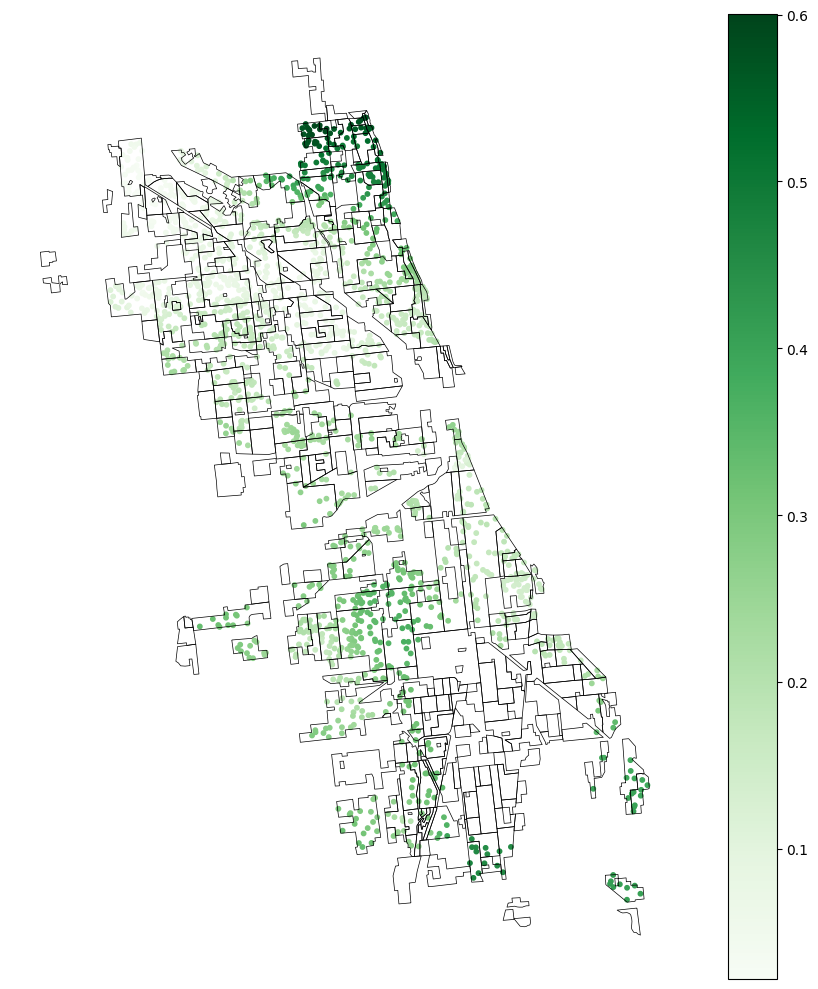

In [158]:

gdf['pDev'] = gwr_model_adapt.pDev
improved_fit_gdf = gdf[gdf['pDev'] > 0.]
# gdf['t_value'] = gwr_model_adapt.tvalues[:, variable_index]

# # Get filtered t-values (if available in your GWR implementation)
# # If not available, you can use a threshold, e.g., abs(t_value) > 1.96 for p < 0.05
# if hasattr(gwr_model_adapt, 'filter_tvals'):
#     filter_tc = gwr_model_adapt.filter_tvals()
#     gdf['significant'] = filter_tc[:, variable_index] != 0
# else:
#     gdf['significant'] = np.abs(gdf['t_value']) > 1.96

# # Create the plot
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# # # Plot all parameter estimates
# # scatter1 = gdf.plot(column='parameter_estimate', ax=ax1, legend=True, 
# #                     cmap='viridis', markersize=20, alpha=0.7)
# # ax1.set_title("All Parameter Estimates")
# # ax1.axis('off')

# # Plot significant parameter estimates
# significant_points = gdf[gdf['significant']]
# non_significant_points = gdf[~gdf['significant']]


#non_significant_points.plot(ax=ax, color='grey', markersize=10, alpha=0.5)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

scatter3 = gdf.plot(column='pDev', ax=ax, legend=True, 
                                   cmap='Greens', markersize=10, alpha=1)

fcc_holc.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.5)
#ax.set_title("Significant Parameter Estimates")
ax.axis('off')

plt.tight_layout()
plt.show()

In [55]:
gdf['pDev'].describe()

count    1697.000000
mean        0.212851
std         0.123010
min         0.022024
25%         0.120466
50%         0.190511
75%         0.281420
max         0.600289
Name: pDev, dtype: float64